In [1]:

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

results_path = "results/final"

In [2]:
# Diccionario para almacenar los datos
resultados = {}

# Recorrer las carpetas de semillas
for seed in os.listdir(results_path):
    ruta_seed = os.path.join(results_path, seed)
    
    # Verificar que sea un directorio
    if os.path.isdir(ruta_seed):
        # Recorrer las carpetas de modelos dentro de cada semilla
        for carpeta in os.listdir(ruta_seed):
            ruta_carpeta = os.path.join(ruta_seed, carpeta)

            if os.path.isdir(ruta_carpeta):
                # Extraer información del nombre de la carpeta
                partes = carpeta.split('_')
                if len(partes) < 4:
                    continue  # Saltar si el formato del nombre no es válido

                timestamp, libreria, modelo, complejidad = partes

                # Inicializar estructura si no existe
                if modelo not in resultados:
                    resultados[modelo] = {}
                if libreria not in resultados[modelo]:
                    resultados[modelo][libreria] = {}
                if seed not in resultados[modelo][libreria]:
                    resultados[modelo][libreria][seed] = {}

                # Cargar los CSV en DataFrames
                for archivo in os.listdir(ruta_carpeta):
                    if archivo.endswith(".csv"):
                        ruta_csv = os.path.join(ruta_carpeta, archivo)
                        nombre_csv = os.path.splitext(archivo)[0]  # Nombre sin extensión
                        df = pd.read_csv(ruta_csv)

                        # Guardar el DataFrame en la estructura
                        resultados[modelo][libreria][seed][nombre_csv] = df

# Estructura final: {modelo -> libreria -> seed -> {nombre_csv -> DataFrame}}

In [3]:
global_metrics_list = []

for modelo, librerias in resultados.items():
    for libreria, semillas in librerias.items():
        for semilla, datos in semillas.items():
            
            if "global_metrics" in datos:
                df = datos["global_metrics"].copy()  # Copiar el DataFrame para modificarlo
                df["training_time"] = df["training_time"] / 60
                global_metrics_list.append(df)
                
global_metrics_df = pd.concat(global_metrics_list, ignore_index=True)
global_metrics_df = global_metrics_df.sort_values(by=["model_type", "model_complexity"])

In [4]:
global_metrics_df.head(20)


,backend,model_type,model_complexity,epochs,batch_size,seed,gpus,definition_time,training_time,testing_time,gpu_0_memory_total
15,jax,cnn,simple,100,64,42,0,3.075443,2.462172,0.197055,24570.0
16,jax,cnn,simple,100,64,43,0,3.103634,2.445377,0.195024,24570.0
17,jax,cnn,simple,100,64,44,0,3.082643,2.475292,0.198647,24570.0
18,jax-keras,cnn,simple,100,64,42,0,0.943785,2.544672,1.801354,24570.0
19,jax-keras,cnn,simple,100,64,43,0,0.949514,2.620215,1.777949,24570.0
20,jax-keras,cnn,simple,100,64,44,0,0.948503,2.767058,1.938005,24570.0
21,tf-keras,cnn,simple,100,64,42,0,1.189420,6.112245,3.555519,24570.0
22,tf-keras,cnn,simple,100,64,43,0,1.180701,6.176248,3.593837,24570.0
23,tf-keras,cnn,simple,100,64,44,0,1.148515,6.190339,3.651145,24570.0
24,torch-keras,cnn,simple,100,64,42,0,0.257313,10.050851,1.900842,24570.0


/tmp/ipykernel_1623099/1936848312.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


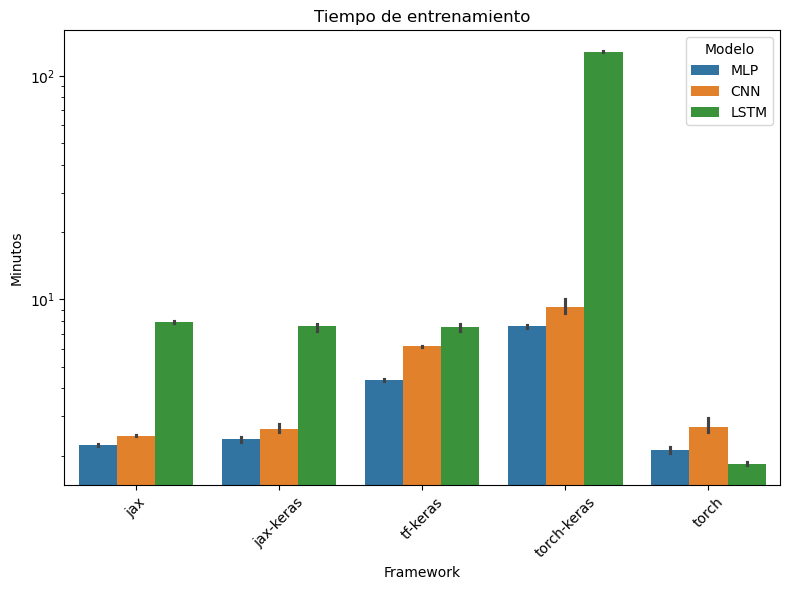

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

orden = ["mlp", "cnn", "lstm"]

sns.barplot(
    data=global_metrics_df,
    x="backend",
    y="training_time",
    hue="model_type",
    hue_order=orden,
    ax=ax
)

ax.set_title("Tiempo de entrenamiento")
ax.set_xlabel("Framework")
ax.set_ylabel("Minutos")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(yscale="log")

legend = ax.legend(title='Modelo', loc='upper right' )
for label in legend.get_texts():
    label.set_text(label.get_text().upper())


plt.tight_layout()
plt.show()

/tmp/ipykernel_1623099/4127893376.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


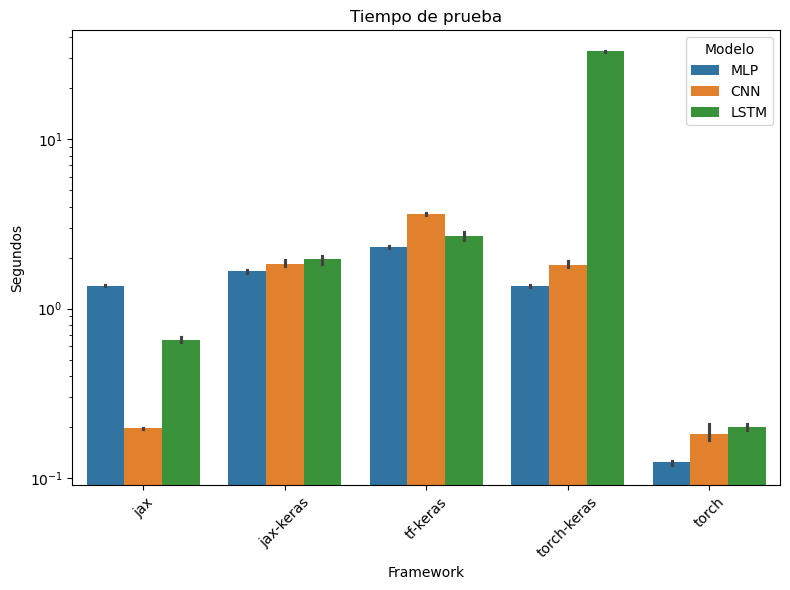

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))  # (1 fila, 2 columnas)

sns.barplot(
    data=global_metrics_df,
    x="backend",
    y="testing_time",
    hue="model_type",
    hue_order=orden,
    ax=ax
)

ax.set_title("Tiempo de prueba")
ax.set_xlabel("Framework")
ax.set_ylabel("Segundos")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(yscale="log")

legend = ax.legend(title='Modelo', loc='upper right' )
for label in legend.get_texts():
    label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()

In [7]:

def get_mean_df(experiments, filename):

    # Lista para almacenar los DataFrames de todas las semillas de una librería
    dfs = []

    for seed, files in experiments.items():
        if filename in files:
            dfs.append(files[filename])

    df_concatenado = pd.concat(dfs, axis=0)  # Stack de los DataFrames
    return df_concatenado.groupby(df_concatenado.index).mean()  # Media fila a fila


In [8]:
def mostrar_graficas(model_type):
    librerias = list(resultados[model_type].keys())
    
    # Crear la figura con 2 filas y 2 columnas
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    fig.suptitle(f"Resultados {model_type.upper()}", fontsize=20)

    # Gráficos: iterar sobre cada librería
    for i, libreria in enumerate(librerias):
        train_samples_df = get_mean_df(resultados[model_type][libreria], "train_samples")
        train_df = get_mean_df(resultados[model_type][libreria], "train")
        
        #train_samples_df = resultados[model_type][libreria][seed].get("train_samples")
        #train_df = resultados[model_type][libreria][seed].get("train")
        
        # Gráfico 1: GPU Utilization vs Timestamp
        sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_0_utilization", ax=axes[0, 0], label=libreria)
        
        # Gráfico 2: GPU Memory Used vs Timestamp
        sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_0_memory_used", ax=axes[0, 1], label=libreria)
        
        # Gráfico 3: GPU Power vs Timestamp
        sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_0_power", ax=axes[1, 0], label=libreria)
        
        # Gráfico 4: Epoch Time vs Epoch (de train.csv)
        sns.lineplot(data=train_df, x="epoch", y="epoch_time", ax=axes[1, 1], label=libreria)

    # Configuración de títulos y etiquetas
    axes[0, 0].set_title("GPU Utilization vs Timestamp")
    axes[0, 0].set_xlabel("Timestamp (s)")
    axes[0, 0].set_ylabel("GPU Utilization (%)")

    axes[0, 1].set_title("GPU Memory Used vs Timestamp")
    axes[0, 1].set_xlabel("Timestamp (s)")
    axes[0, 1].set_ylabel("GPU Memory Used (MB)")

    axes[1, 0].set_title("GPU Power vs Timestamp")
    axes[1, 0].set_xlabel("Timestamp (s)")
    axes[1, 0].set_ylabel("GPU Power (W)")

    axes[1, 1].set_title("Epoch Time vs Epoch")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Epoch Time (s)")

    # Agregar leyendas
    for i, ax in enumerate(axes.flat):
        ax.legend(title="Librería")
        if model_type == "lstm":
            if i < 3:
                ax.set(xscale="log")
            else:
                ax.set(yscale="log")

    # Ajustar diseño para evitar solapamiento
    plt.tight_layout()
    
    # Mostrar la figura
    plt.show()

In [9]:
def mostrar_graficas(model_type):
    librerias = list(resultados[model_type].keys())
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    fig.suptitle(f"Resultados {model_type.upper()}", fontsize=20)

    # Gráficos: iterar sobre cada librería
    for i, libreria in enumerate(librerias):
        train_samples_df = get_mean_df(resultados[model_type][libreria], "train_samples")
        
        # Gráfico 1: GPU Utilization vs Timestamp
        sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_0_utilization", ax=axes[0], label=libreria)
        
        # Gráfico 3: GPU Power vs Timestamp
        sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_0_power", ax=axes[1], label=libreria)


    # Configuración de títulos y etiquetas
    axes[0].set_title("Uso de la GPU (entrenamiento)")
    axes[0].set_xlabel("Tiempo (s)")
    axes[0].set_ylabel("Uso GPU (%)")

    axes[1].set_title("Consumo instantáneo de la GPU (entrenamiento)")
    axes[1].set_xlabel("Tiempo (s)")
    axes[1].set_ylabel("Consumo instantáneo (W)")

    # Agregar leyendas
    for i, ax in enumerate(axes.flat):
        ax.legend(title="Framework")
        if model_type == "lstm":
            if i < 3:
                ax.set(xscale="log")
            else:
                ax.set(yscale="log")

    # Ajustar diseño para evitar solapamiento
    plt.tight_layout()
    
    # Mostrar la figura
    plt.show()

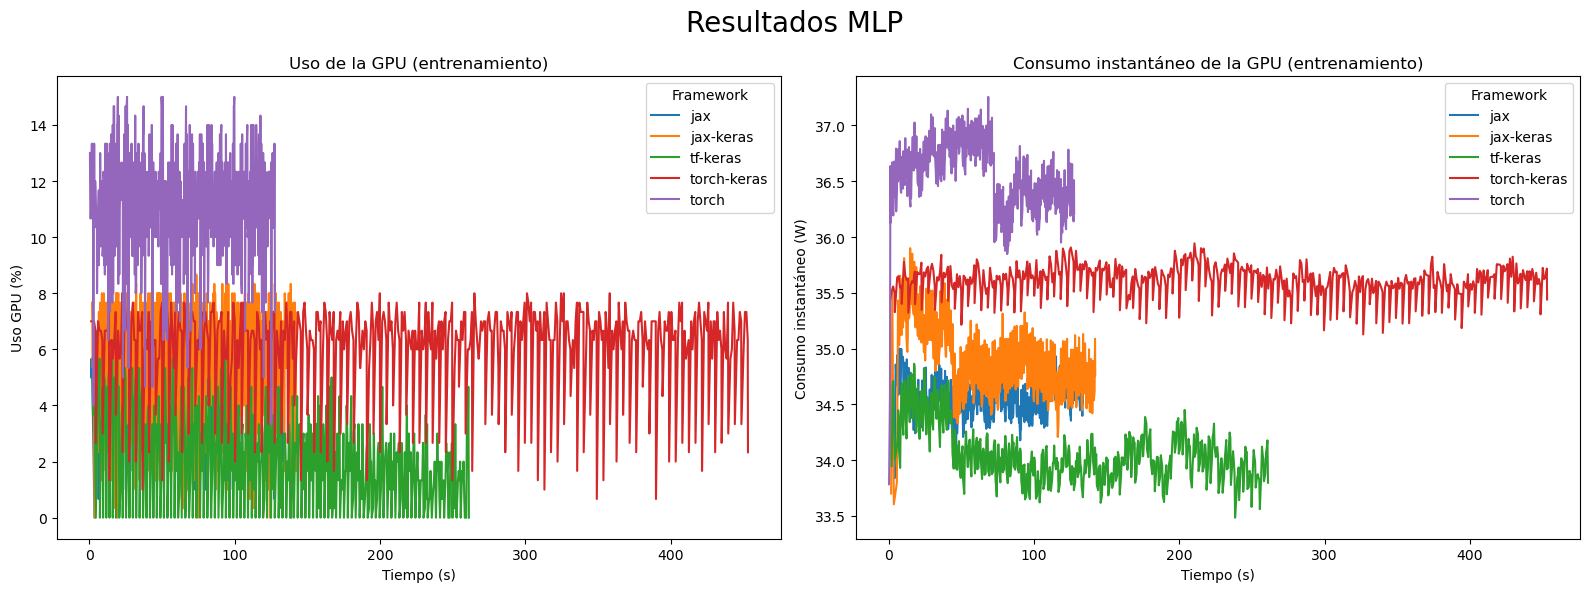

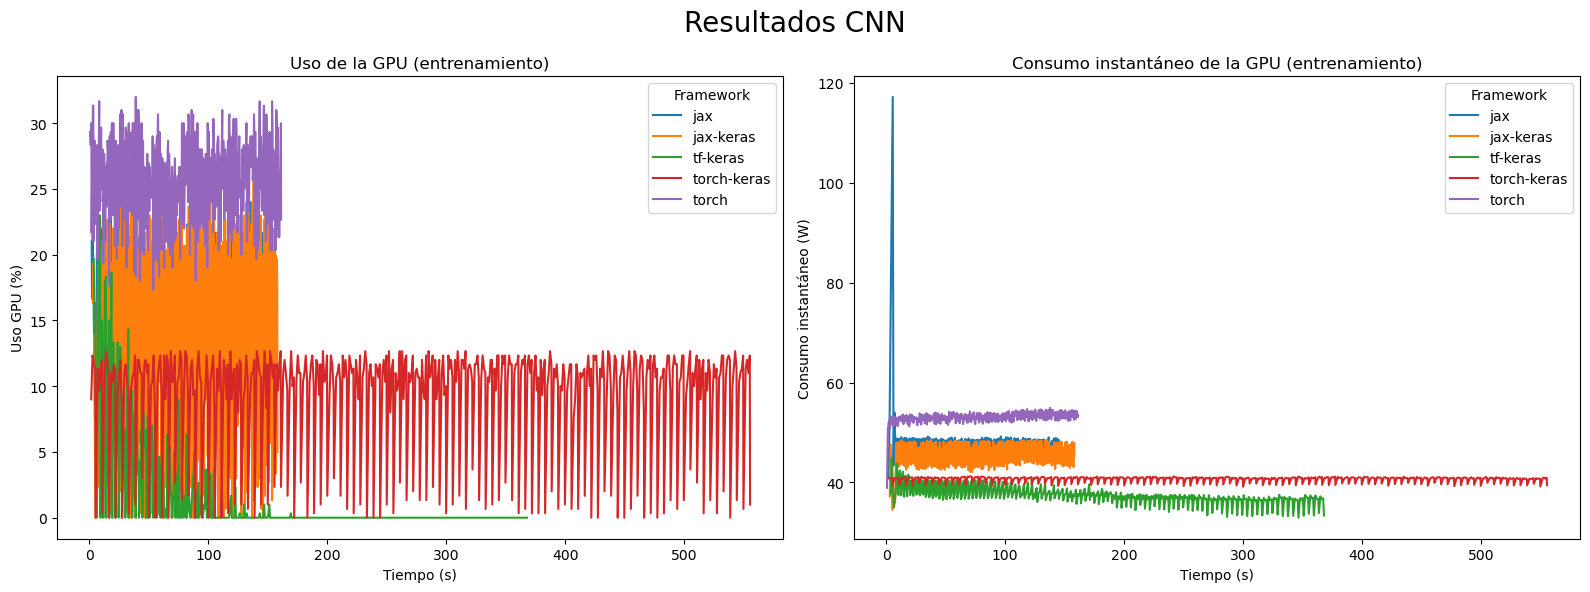

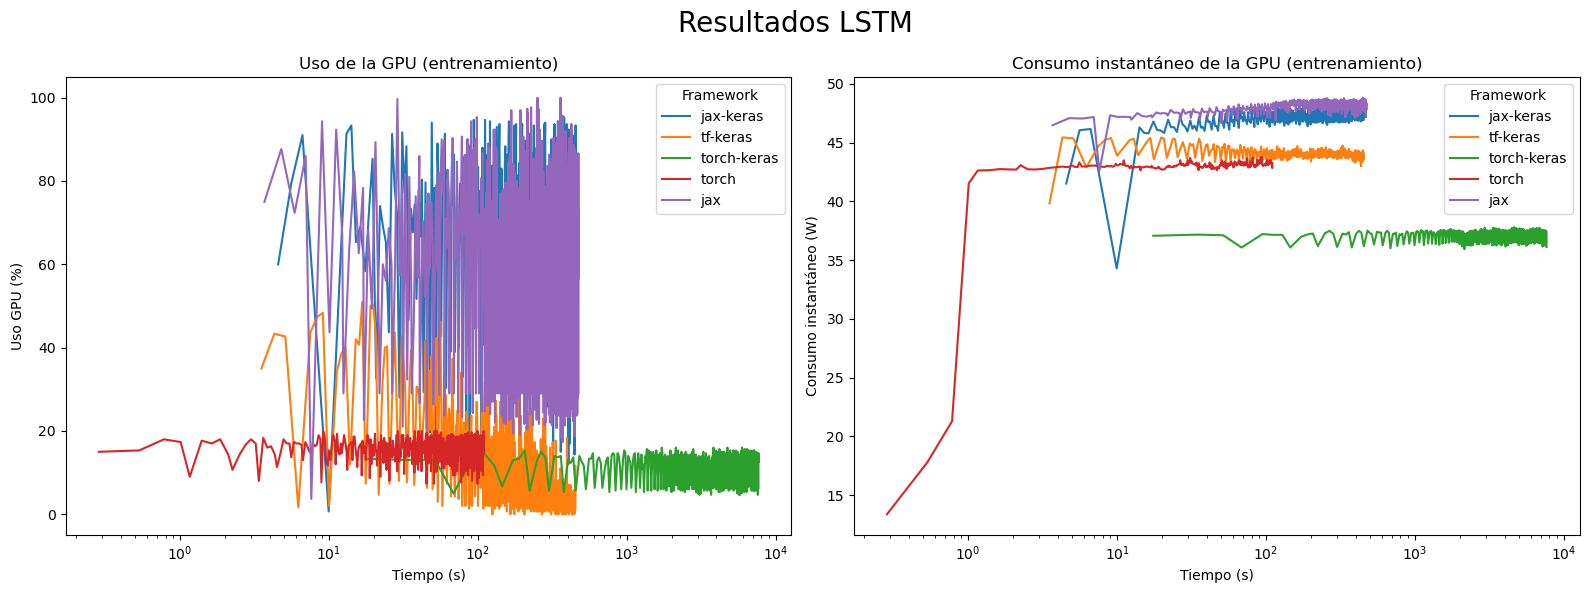

In [10]:
mostrar_graficas("mlp")
mostrar_graficas("cnn")
mostrar_graficas("lstm")

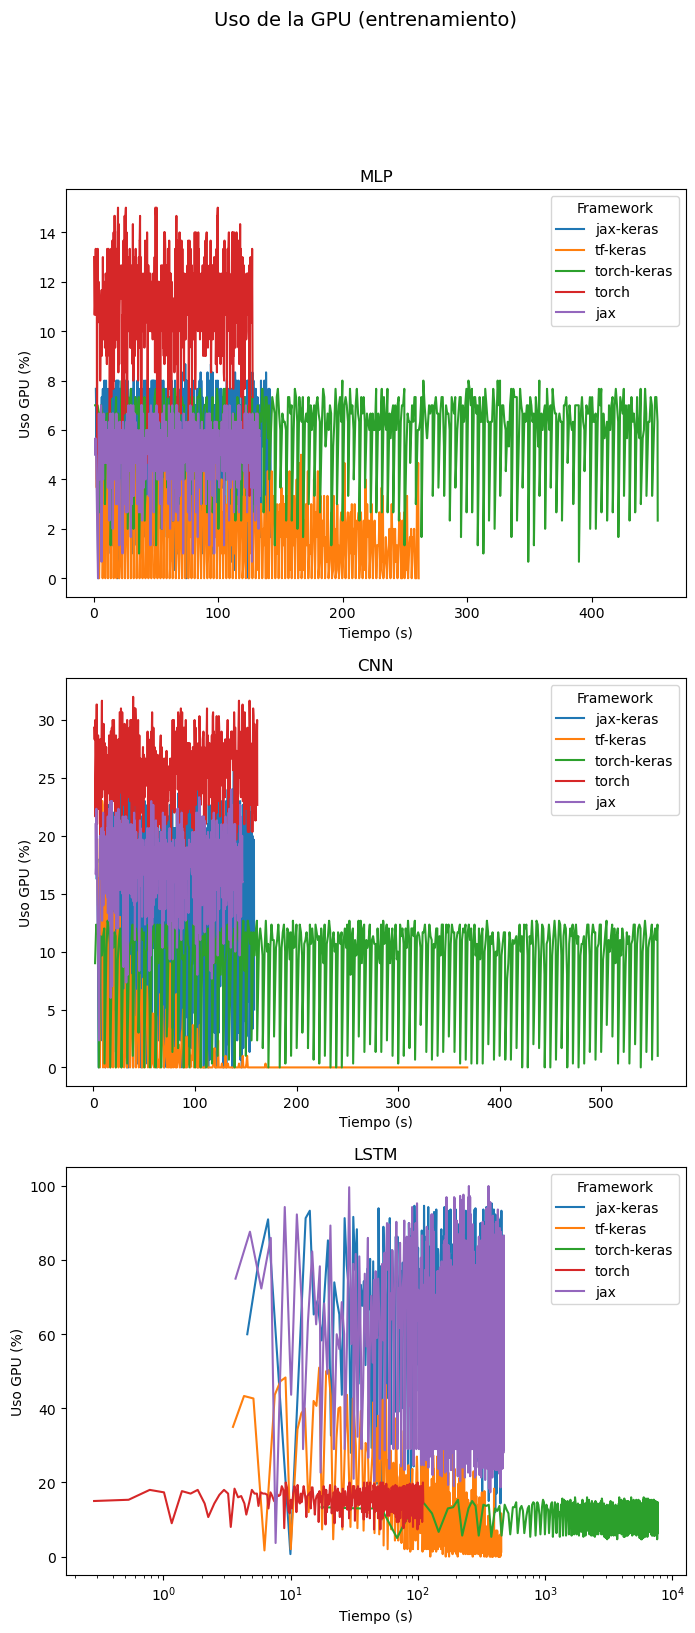

In [11]:
   
fig, axes = plt.subplots(3, 1, figsize=(8, 18))

fig.suptitle("Uso de la GPU (entrenamiento)", fontsize=14)

for i, modelo in enumerate(resultados):
    ax = axes[i]
    for libreria in librerias:
        train_samples_df = get_mean_df(resultados[modelo][libreria], "train_samples")
        
        # Gráfico 1: GPU Utilization vs Timestamp
        sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_0_utilization", ax=ax, label=libreria)
        
        # Gráfico 3: GPU Power vs Timestamp
        #sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_0_power", ax=ax, label=libreria)


    # Configuración de títulos y etiquetas
    ax.set_title(modelo.upper())
    ax.set_xlabel("Tiempo (s)")
    ax.set_ylabel("Uso GPU (%)")

#axes[1].set_title("Consumo instantáneo de la GPU (entrenamiento)")
#axes[1].set_xlabel("Tiempo (s)")
#axes[1].set_ylabel("Consumo instantáneo (W)")

# Agregar leyendas
    ax.legend(title="Framework")
    if modelo == "lstm":
        if i < 3:
            ax.set(xscale="log")
        else:
            ax.set(yscale="log")

# Mostrar la figura
plt.show()

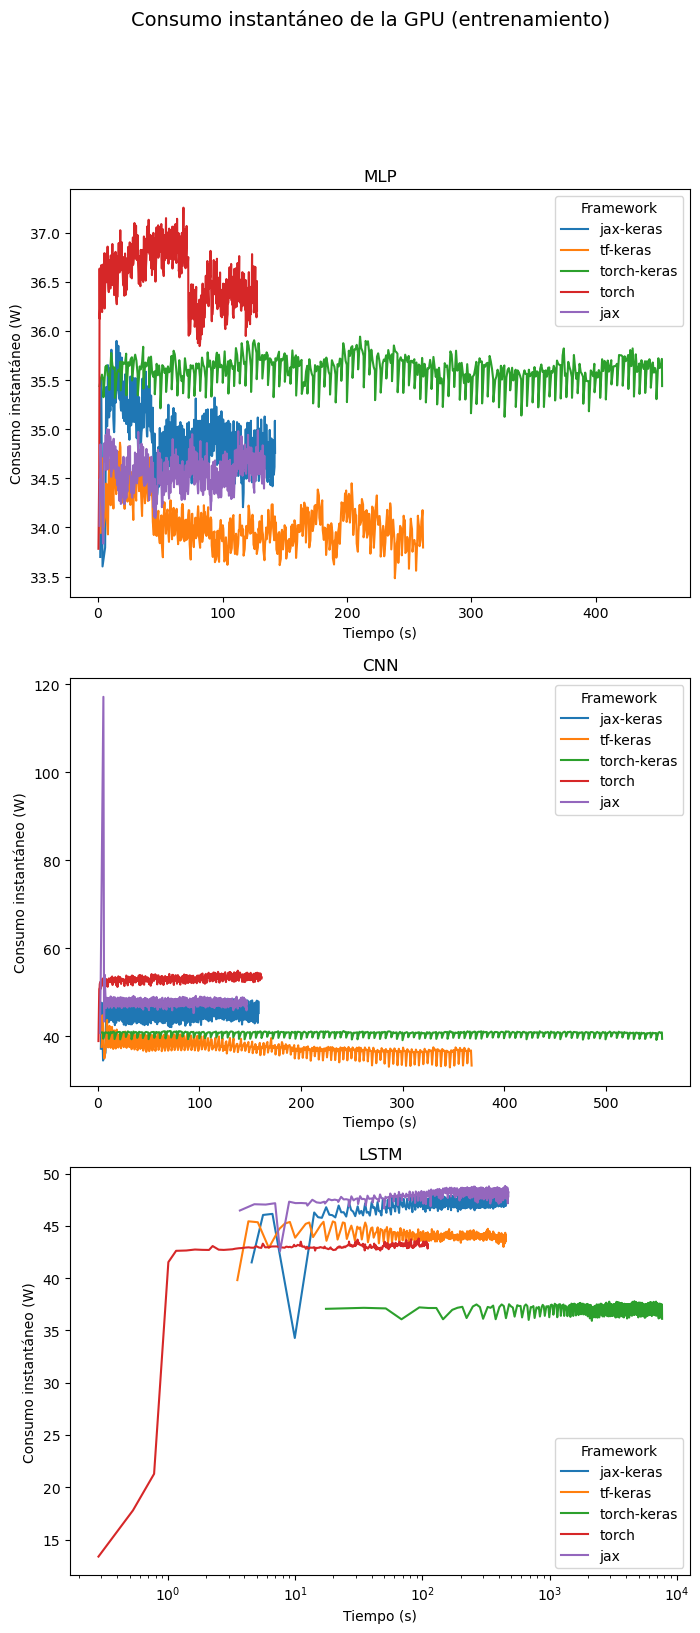

In [12]:
   
fig, axes = plt.subplots(3, 1, figsize=(8, 18))

fig.suptitle("Consumo instantáneo de la GPU (entrenamiento)", fontsize=14)

for i, modelo in enumerate(resultados):
    ax = axes[i]
    for libreria in librerias:
        train_samples_df = get_mean_df(resultados[modelo][libreria], "train_samples")
        
        sns.lineplot(data=train_samples_df, x="timestamp", y="gpu_0_power", ax=ax, label=libreria)


    # Configuración de títulos y etiquetas
    ax.set_title(modelo.upper())
    ax.set_xlabel("Tiempo (s)")
    ax.set_ylabel("Consumo instantáneo (W)")

# Agregar leyendas
    ax.legend(title="Framework")
    if modelo == "lstm":
        if i < 3:
            ax.set(xscale="log")
        else:
            ax.set(yscale="log")

# Mostrar la figura
plt.show()

/tmp/ipykernel_1623099/905230906.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


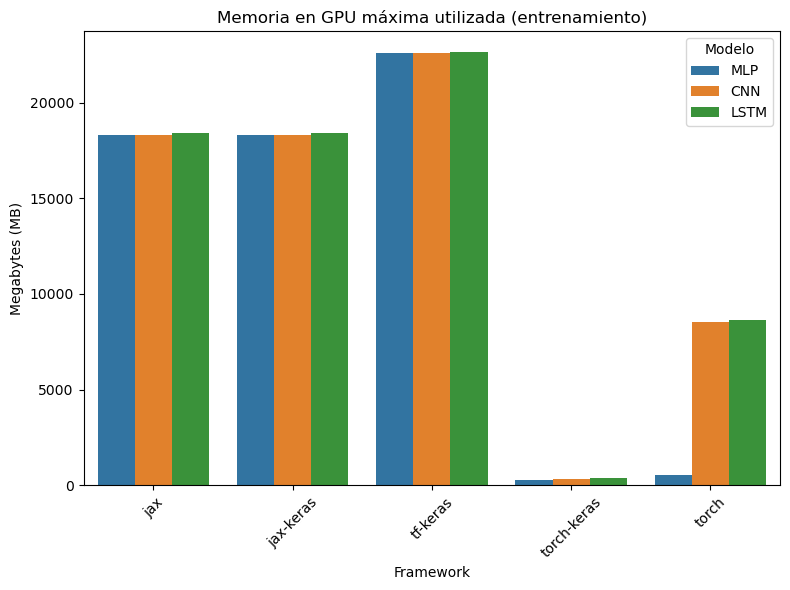

In [13]:
memory_dfs = []

for modelo, librerias in resultados.items():
    for libreria, semillas in librerias.items():
        for semilla, datos in semillas.items():
            
            if "train_samples" in datos:
                train_samples_df = datos["train_samples"].copy()
                df = pd.DataFrame({
                    "model_type": [modelo],
                    "framework": [libreria],
                    "memory_used": [train_samples_df["gpu_0_memory_used"].max()]
                })
                memory_dfs.append(df)
                
memory_df = pd.concat(memory_dfs, ignore_index=True)


fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=memory_df,
    x="framework",
    y="memory_used",
    hue="model_type",
    hue_order=orden,
    ax=ax
)

ax.set_title("Memoria en GPU máxima utilizada (entrenamiento)")
ax.set_xlabel("Framework")
ax.set_ylabel("Megabytes (MB)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#ax.set(yscale="log")

legend = ax.legend(title='Modelo', loc='upper right' )
for label in legend.get_texts():
    label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()

/tmp/ipykernel_1623099/2026235316.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


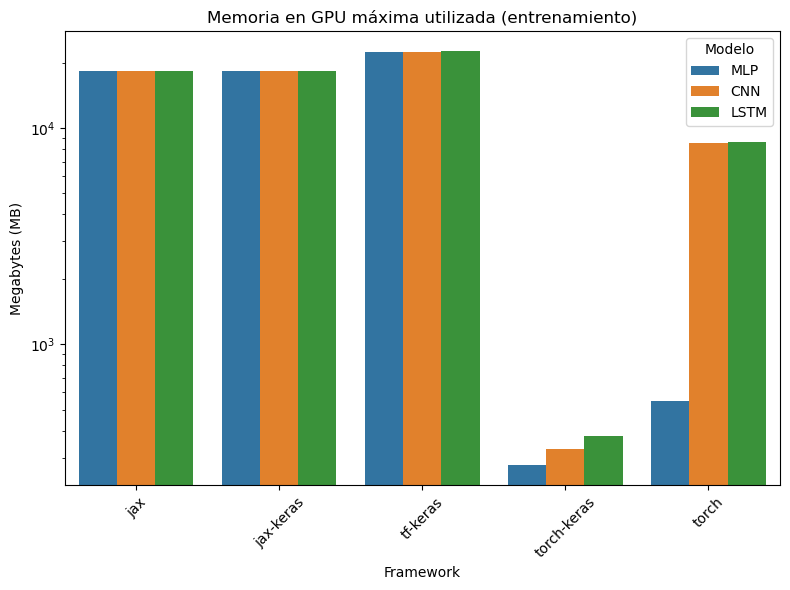

In [14]:
memory_dfs = []

for modelo, librerias in resultados.items():
    for libreria, semillas in librerias.items():
        for semilla, datos in semillas.items():
            
            if "train_samples" in datos:
                train_samples_df = datos["train_samples"].copy()
                df = pd.DataFrame({
                    "model_type": [modelo],
                    "framework": [libreria],
                    "memory_used": [train_samples_df["gpu_0_memory_used"].max()]
                })
                memory_dfs.append(df)
                
memory_df = pd.concat(memory_dfs, ignore_index=True)


fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=memory_df,
    x="framework",
    y="memory_used",
    hue="model_type",
    hue_order=orden,
    ax=ax
)

ax.set_title("Memoria en GPU máxima utilizada (entrenamiento)")
ax.set_xlabel("Framework")
ax.set_ylabel("Megabytes (MB)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(yscale="log")

legend = ax.legend(title='Modelo', loc='upper right' )
for label in legend.get_texts():
    label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()

/tmp/ipykernel_1580103/2437692855.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


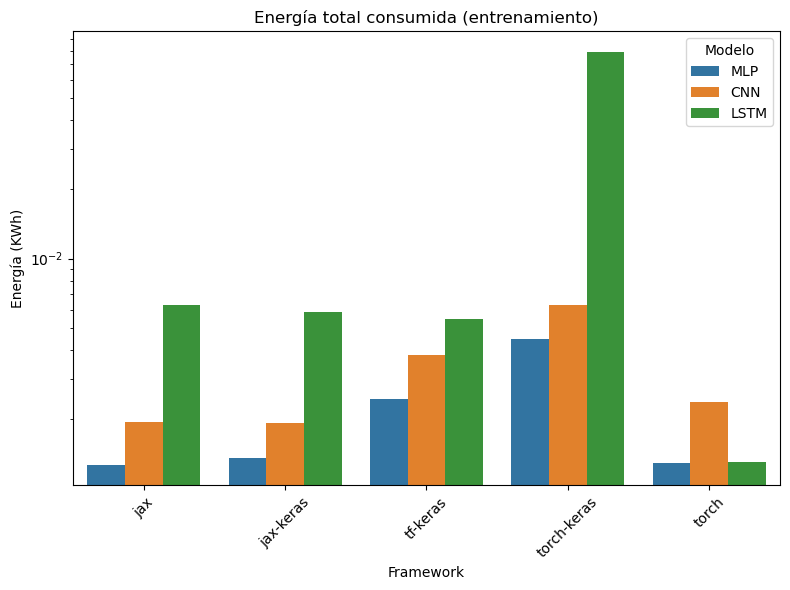

In [18]:

# Julios = vatios * segundos
energia_total = []

for modelo in resultados:
    for libreria in resultados[modelo]:
        train_samples_df = get_mean_df(resultados[modelo][libreria], "train_samples")

        # Ordenar por timestamp (por si acaso no lo estuviesen)
        train_samples_df = train_samples_df.sort_values(by="timestamp").reset_index(drop=True)

        # Calcular delta_t (diferencia de tiempo entre muestras en segundos)
        train_samples_df["delta_t"] = train_samples_df["timestamp"].diff().fillna(0)

        # Calcular la energía consumida en cada intervalo (P * delta_t)
        train_samples_df["energia"] = train_samples_df["gpu_0_power"] * train_samples_df["delta_t"]

        # Sumar toda la energía consumida
        energia_total.append({
            "modelo": modelo,
            "libreria": libreria,
            "energia": train_samples_df["energia"].sum() / (1000 * 3600) # pasar de J a KWh
        })

df_energia = pd.DataFrame(energia_total)

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=df_energia,
    x="libreria",
    y="energia",
    hue="modelo",
    ax=ax
)

ax.set_title("Energía total consumida (entrenamiento)")
ax.set_xlabel("Framework")
ax.set_ylabel("Energía (KWh)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(yscale="log")

legend = ax.legend(title='Modelo', loc='upper right' )
for label in legend.get_texts():
    label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()


/tmp/ipykernel_1580103/3297175451.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


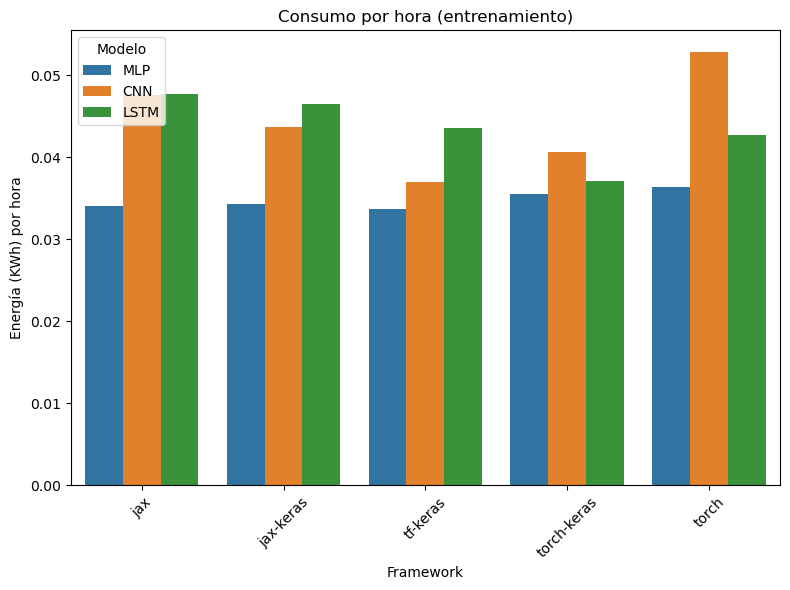

In [19]:

# Julios = vatios * segundos
energia_total = []

for modelo in resultados:
    for libreria in resultados[modelo]:
        train_samples_df = get_mean_df(resultados[modelo][libreria], "train_samples")

        # Ordenar por timestamp (por si acaso no lo estuviesen)
        train_samples_df = train_samples_df.sort_values(by="timestamp").reset_index(drop=True)

        # Calcular delta_t (diferencia de tiempo entre muestras en segundos)
        train_samples_df["delta_t"] = train_samples_df["timestamp"].diff().fillna(0)

        # Calcular la energía consumida en cada intervalo (P * delta_t)
        train_samples_df["energia"] = train_samples_df["gpu_0_power"] * train_samples_df["delta_t"]

        # Tiempo de entrenamiento
        tiempos = []
        for semilla in resultados[modelo][libreria]:
            tiempos.append(resultados[modelo][libreria][semilla]["global_metrics"]["training_time"])

        tiempo = np.mean(tiempos)

        # Sumar toda la energía consumida
        energia_total.append({
            "modelo": modelo,
            "libreria": libreria,
            "energia": (train_samples_df["energia"].sum() / (1000)) / tiempo
        })

df_energia = pd.DataFrame(energia_total)

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=df_energia,
    x="libreria",
    y="energia",
    hue="modelo",
    ax=ax
)

ax.set_title("Consumo por hora (entrenamiento)")
ax.set_xlabel("Framework")
ax.set_ylabel("Energía (KWh) por hora")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#a

legend = ax.legend(title='Modelo', loc='upper left' )
for label in legend.get_texts():
    label.set_text(label.get_text().upper())

plt.tight_layout()
plt.show()


In [20]:

all_test_results = []

for modelo in resultados:
    for libreria in resultados[modelo]:
        test_df = get_mean_df(resultados[modelo][libreria], "test")
        test_df["model_type"] = modelo
        test_df["framework"] = libreria
        all_test_results.append(test_df)

test_results_df = pd.concat(all_test_results, ignore_index=True)

In [21]:
test_results_df.head(20)

,loss,accuracy,epoch_time,model_type,framework,mae
0,0.363075,0.896900,1.367812,mlp,jax,NaN
1,0.347110,0.900067,1.666253,mlp,jax-keras,NaN
2,0.360937,0.900100,2.176333,mlp,tf-keras,NaN
3,0.344254,0.902200,1.366592,mlp,torch-keras,NaN
4,1.569468,0.891500,0.115200,mlp,torch,NaN
5,0.825321,0.728333,0.196868,cnn,jax,NaN
6,0.805646,0.730967,1.836654,cnn,jax-keras,NaN
7,0.788290,0.736267,3.327856,cnn,tf-keras,NaN
8,0.792407,0.734433,1.814579,cnn,torch-keras,NaN
9,1.811514,0.649267,0.149758,cnn,torch,NaN


/tmp/ipykernel_1580103/23592367.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_1580103/23592367.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


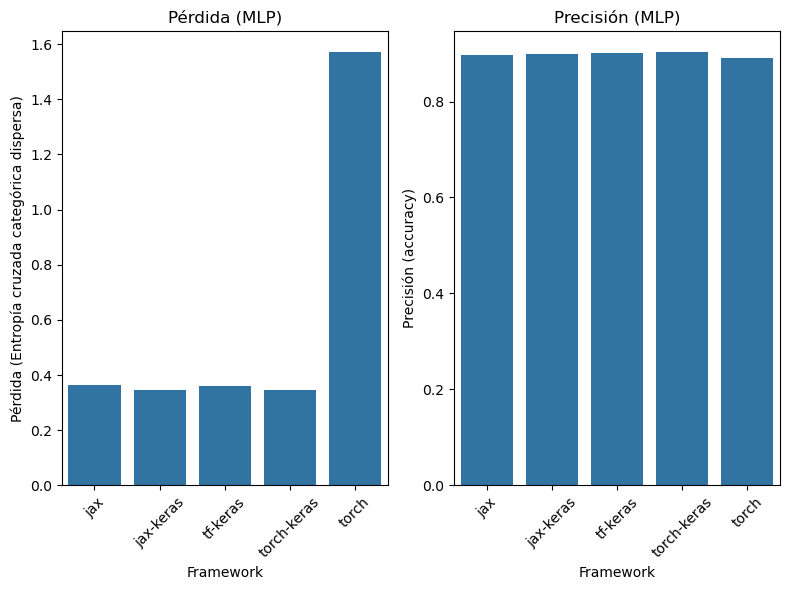

In [22]:

df = test_results_df[test_results_df["model_type"] == "mlp"]

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

sns.barplot(
    data=df,
    x="framework",
    y="loss",
    hue="model_type",
    ax=axes[0]
)

axes[0].set_title("Pérdida (MLP)")
axes[0].set_xlabel("Framework")
axes[0].set_ylabel("Pérdida (Entropía cruzada categórica dispersa)")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


sns.barplot(
    data=df,
    x="framework",
    y="accuracy",
    hue="model_type",
    ax=axes[1]
)

axes[1].set_title(f"Precisión (MLP)")
axes[1].set_xlabel("Framework")
axes[1].set_ylabel("Precisión (accuracy)")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


for i, ax in enumerate(axes.flat):
    ax.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1580103/2124072207.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_1580103/2124072207.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


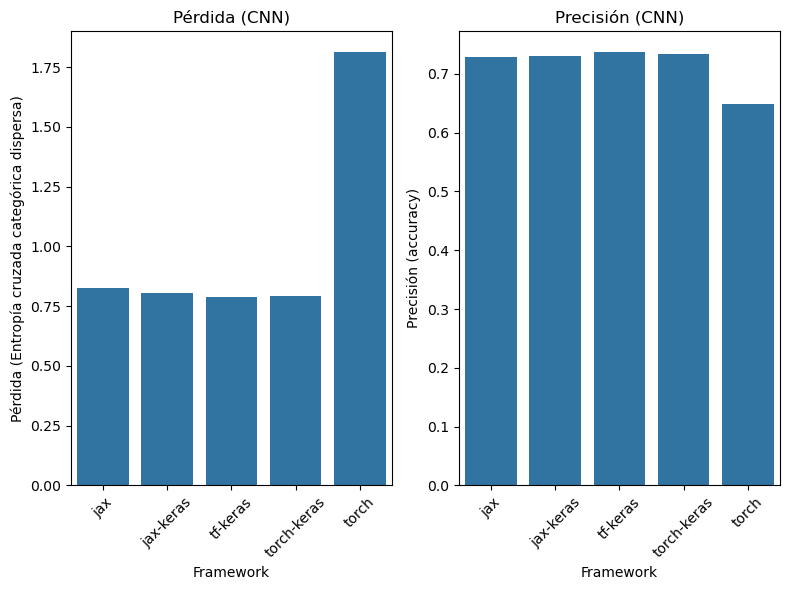

In [23]:

df = test_results_df[test_results_df["model_type"] == "cnn"]

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

sns.barplot(
    data=df,
    x="framework",
    y="loss",
    hue="model_type",
    ax=axes[0]
)

axes[0].set_title("Pérdida (CNN)")
axes[0].set_xlabel("Framework")
axes[0].set_ylabel("Pérdida (Entropía cruzada categórica dispersa)")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


sns.barplot(
    data=df,
    x="framework",
    y="accuracy",
    hue="model_type",
    ax=axes[1]
)

axes[1].set_title(f"Precisión (CNN)")
axes[1].set_xlabel("Framework")
axes[1].set_ylabel("Precisión (accuracy)")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


for i, ax in enumerate(axes.flat):
    ax.legend([],[], frameon=False)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1580103/1385529771.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipykernel_1580103/1385529771.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


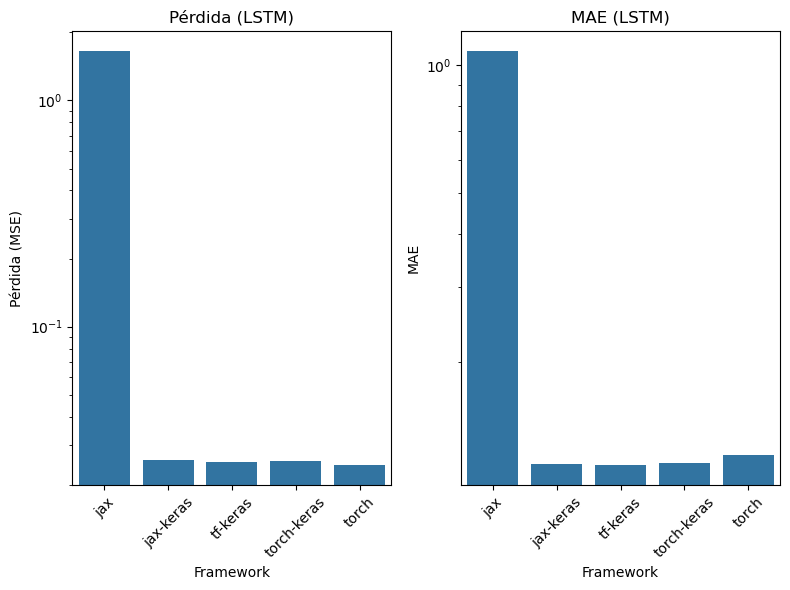

In [24]:

df = test_results_df[test_results_df["model_type"] == "lstm"]

fig, axes = plt.subplots(1, 2, figsize=(8, 6))

sns.barplot(
    data=df,
    x="framework",
    y="loss",
    hue="model_type",
    order=["jax", "jax-keras", "tf-keras", "torch-keras", "torch"],
    ax=axes[0]
)

axes[0].set_title("Pérdida (LSTM)")
axes[0].set_xlabel("Framework")
axes[0].set_ylabel("Pérdida (MSE)")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


sns.barplot(
    data=df,
    x="framework",
    y="mae",
    hue="model_type",
    order=["jax", "jax-keras", "tf-keras", "torch-keras", "torch"],
    ax=axes[1]
)

axes[1].set_title("MAE (LSTM)")
axes[1].set_xlabel("Framework")
axes[1].set_ylabel("MAE")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


for i, ax in enumerate(axes.flat):
    ax.legend([],[], frameon=False)
    ax.set(yscale="log")

plt.tight_layout()
plt.show()